In [9]:
import pandas as pd
import tensorflow as tf

from sklearn.mixture import GaussianMixture

from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import math
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image

from joblib import dump, load

In [127]:
class Autoencoder(Model):

    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(32, 32, 1)),
            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(latent_dim, activation='relu')
            ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(256, activation='relu'), 
            layers.Dense(526, activation='relu'), 
            layers.Dense(1024, activation='relu'),
            layers.Reshape((32, 32))])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [174]:
num_page = 0

kmnist_page = Image.open(f'../data/winnie-kmnist/{num_page}.png')

In [175]:
kmnist_data = []

letter_size = 32
letters_per_width = 80
letters_per_height = 114

where_blank = []

k_page = np.array(kmnist_page)[:,:,0]/255

for l_h in range(letters_per_height):
    for l_w in range(letters_per_width):
        if sum(sum(k_page[l_h * letter_size:(l_h + 1) * letter_size,l_w * letter_size:(l_w + 1) * letter_size])) > 80:
            kmnist_data.append(k_page[l_h * letter_size:(l_h + 1) * letter_size,l_w * letter_size:(l_w + 1) * letter_size])
        else:
            where_blank.append([l_h, l_w])
            
kmnist_data = np.array(kmnist_data)

In [186]:
kmnist_autoencoder =  Autoencoder(5)
emnist_autoencoder =  Autoencoder(5)

kmnist_autoencoder.load_weights('../models/dense-kmnist-1/weigths')
emnist_autoencoder.load_weights('../models/dense-emnist-1/weigths')

kgmm = load('../models/gmm/kgmm.joblib')
egmm = load('../models/gmm/egmm.joblib')

mapping = np.load('../models/mapping.npy',allow_pickle='TRUE').item()

In [187]:
k_encoded = kmnist_autoencoder.encoder(kmnist_data).numpy()
k_labels = kgmm.predict(k_encoded)

e_labels = []
for label in k_labels:
    e_labels.append(mapping[label])

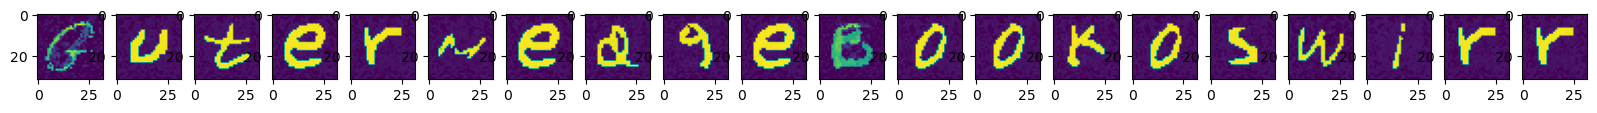

In [188]:
e_coded = egmm.means_[e_labels]
e_mapped = emnist_autoencoder.decoder(e_coded).numpy()
n = 20

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(e_mapped[i+10])

plt.show()

In [189]:
page = []

blank_space = np.full((32, 32), 0)

letters_per_width = 80
letters_per_height = 114

k_page = np.array(kmnist_page)[:,:,0]/255

letter_id = 0
for l_h in range(letters_per_height):
    new_line = []
    for l_w in range(letters_per_width):
        if [l_h, l_w] not in where_blank:
            new_line.append(e_mapped[letter_id])
            letter_id += 1
        else:
            new_line.append(blank_space)
    new_line = np.concatenate(new_line, axis=1) 
    page.append(new_line)
page = np.concatenate(page, axis=0) 

page = page * 255
page[page > 255/2] = 255
page[page <= 255/2] = 0

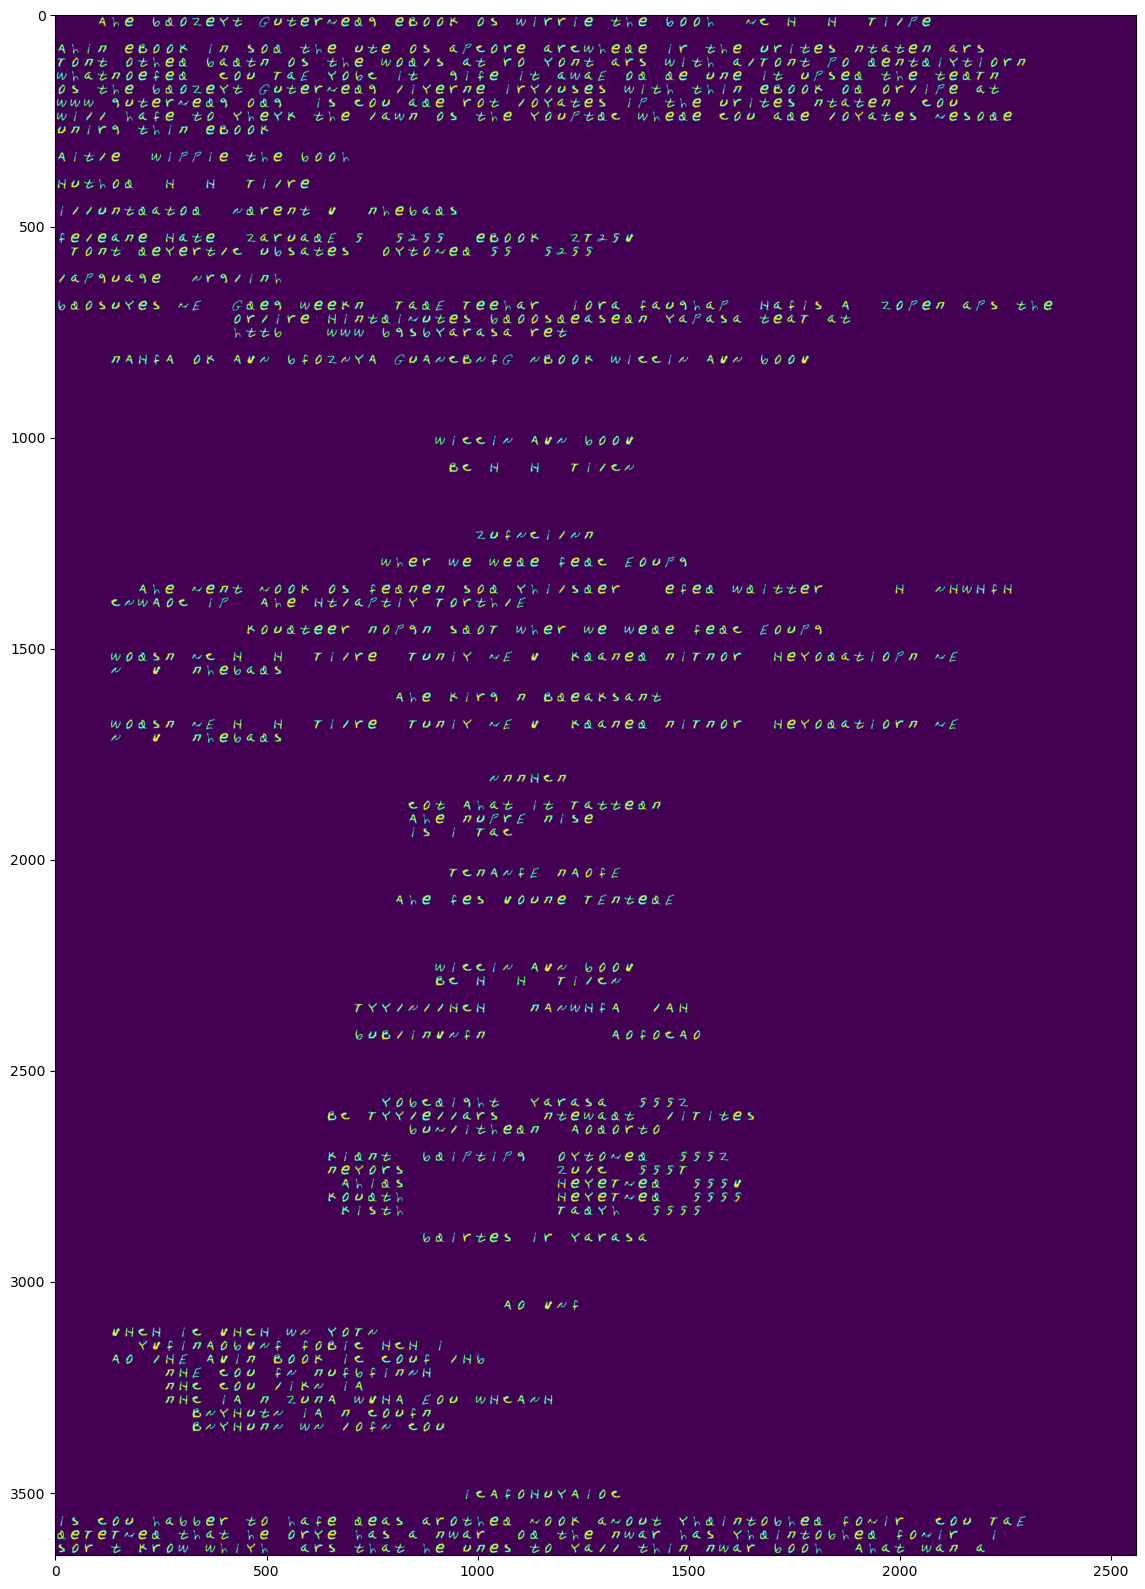

In [190]:
plt.figure(figsize = (20,20))

plt.imshow(page)

In [111]:
im = Image.fromarray(page)
im = im.convert('RGB')

im.save(f'decoded.png')